In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
mydict = np.load('dsec_data.npy',allow_pickle=True)

## load the data

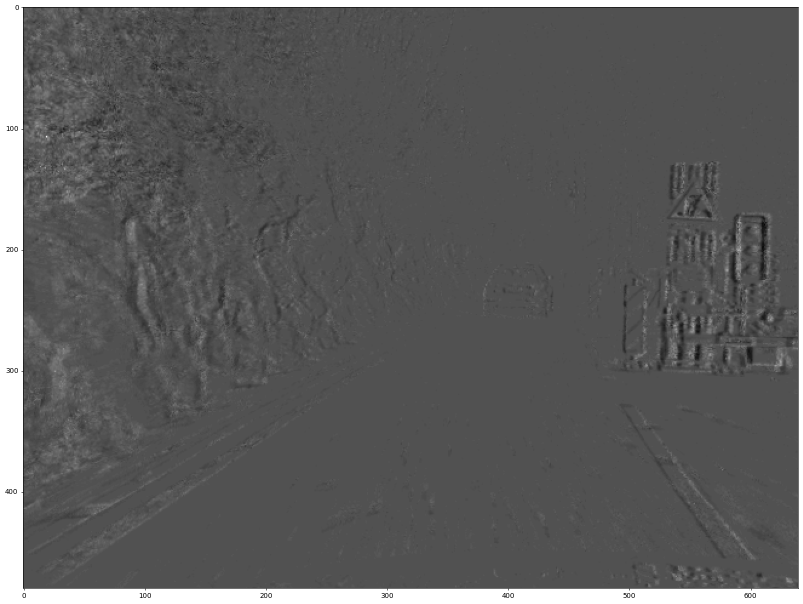

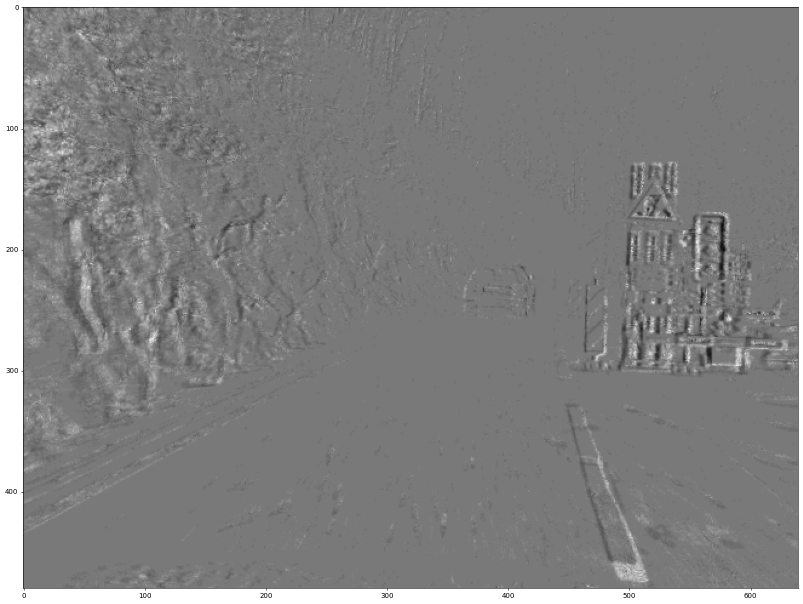

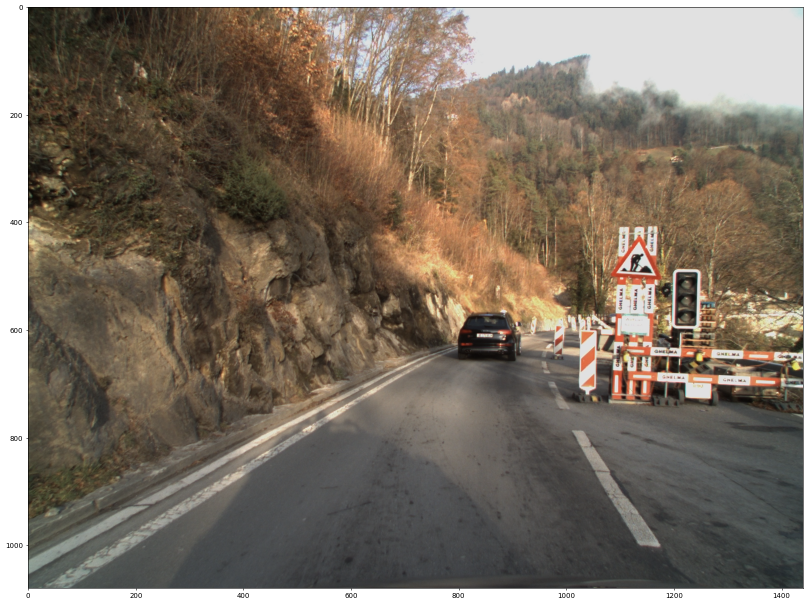

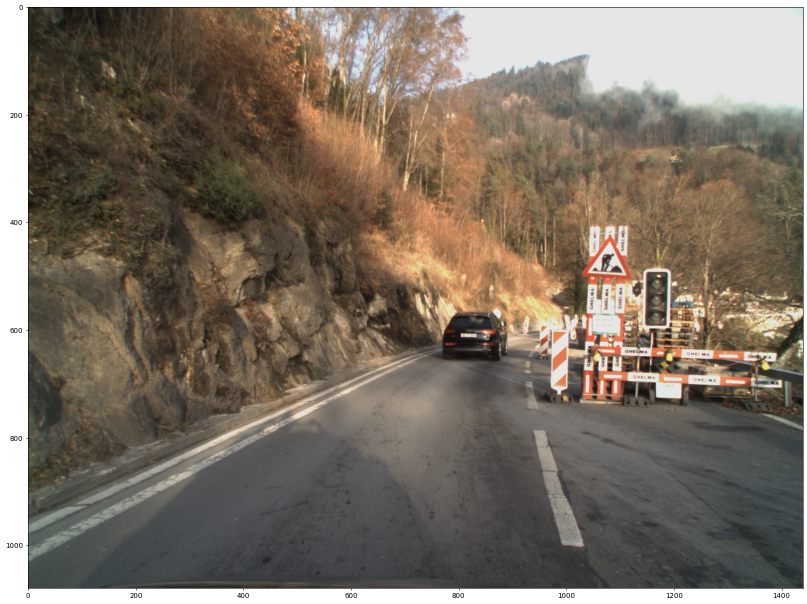

In [8]:
# interlaken_00_c/events/left/events.h5, first 25ms, ts_end=51805200790
left_event = mydict.item()['left_event']
left_event = np.squeeze(left_event)
plt.figure(figsize=(20,20), dpi=50)
plt.imshow(left_event,cmap='gray')

# interlaken_00_c/events/right/events.h5, first 25ms, ts_end=51805200790
right_event = mydict.item()['right_event']
right_event = np.squeeze(right_event)
plt.figure(figsize=(20,20), dpi=50)
plt.imshow(right_event,cmap='gray')

# interlaken_00_c/interlaken_00_c_images_rectified_left/000000.png
left_img = mydict.item()['left_img']
left_img = np.squeeze(left_img)
plt.figure(figsize=(20,20), dpi=50)
plt.imshow(left_img[:,:,[2,1,0]],cmap='gray')

# interlaken_00_c/interlaken_00_c_images_rectified_right/000000.png
right_img = mydict.item()['right_img']
right_img = np.squeeze(right_img)
plt.figure(figsize=(20,20), dpi=50)
plt.imshow(right_img[:,:,[2,1,0]],cmap='gray')

## Fov compare before warp

left cameras original
right cameras original


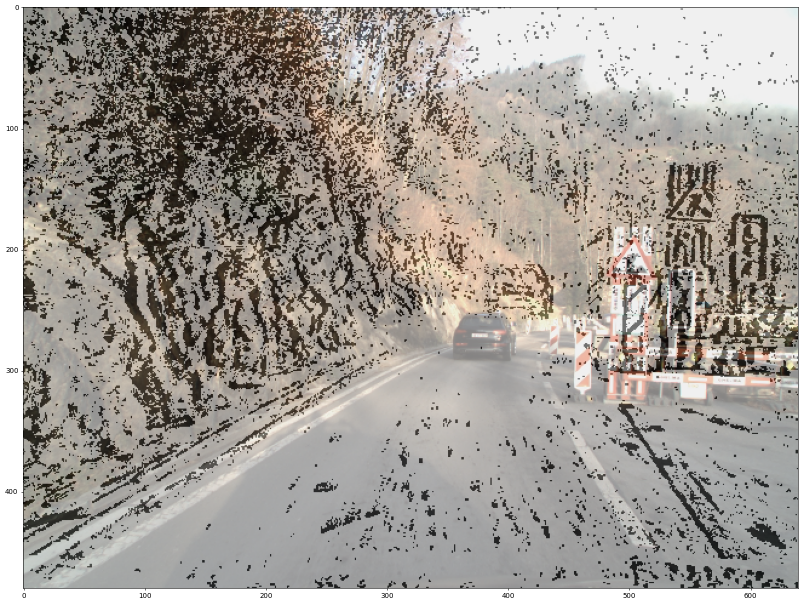

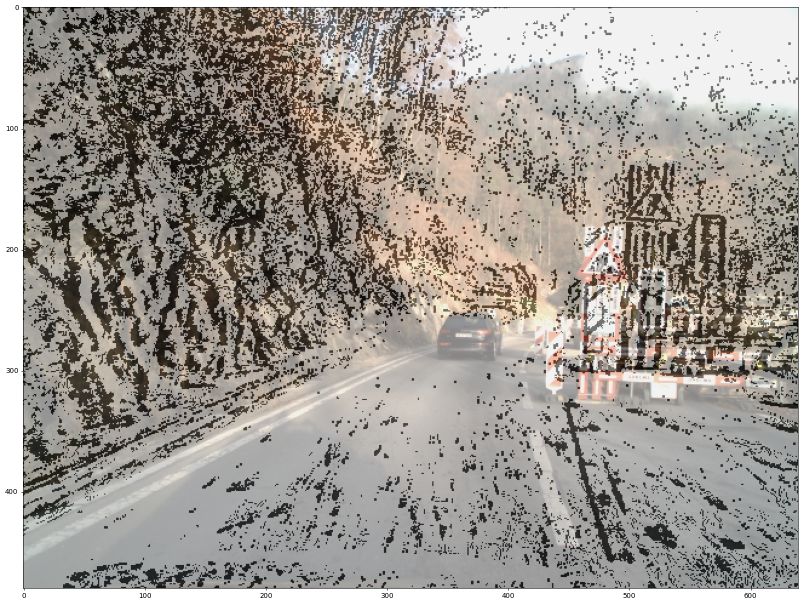

In [13]:
h,w = left_event.shape
left_event_b = left_event*127/abs(left_event).max()+127
ret,left_event_b=cv2.threshold(left_event_b,126,255,cv2.THRESH_BINARY)

left_img_small = cv2.resize(left_img, (w,h))
left_event_3c = np.repeat(left_event_b[:,:,np.newaxis], 3, axis=2)
hikaku = cv2.addWeighted(left_img_small[:,:,[2,1,0]].astype(np.float64), 0.5, (left_event_3c).astype(np.float64), 0.5, 0)

plt.figure(figsize=[20,20], dpi=50)
plt.imshow(hikaku.astype(np.uint8))
print("left cameras original")

right_event_b = right_event*127/abs(right_event).max()+127
ret,right_event_b=cv2.threshold(right_event_b,126,255,cv2.THRESH_BINARY)

right_img_small = cv2.resize(right_img, (w,h))
right_event_3c = np.repeat(right_event_b[:,:,np.newaxis], 3, axis=2)
hikaku2 = cv2.addWeighted(right_img_small[:,:,[2,1,0]].astype(np.float64), 0.5, (right_event_3c).astype(np.float64), 0.5, 0)

plt.figure(figsize=[20,20], dpi=50)
plt.imshow(hikaku2.astype(np.uint8))
print("right cameras original")

## Fov compare after warp

In [14]:
Kr1 = np.array([
    [1164.6238115833075, 0, 713.5791168212891],
    [0, 1164.6238115833075, 570.9349365234375],
    [0,0,1]
])

Kr0 = np.array([
    [569.7632987676102, 0, 335.0999870300293],
    [0, 569.7632987676102, 221.23667526245117],
    [0,0,1]
])

Kr2 = np.array([
    [1164.6238115833075, 0, 713.5791168212891],
    [0, 1164.6238115833075, 570.9349365234375],
    [0,0,1]
])

T32 = np.array([
    [0.9999880111304372, -0.003533401537847065, -0.003390083916194203, -0.04551026028184807],
    [0.003476600244706753, 0.9998558803824363, -0.016617211420558598, -0.001048727690114844],
    [0.0034483106189848347, 0.016605226232405814, 0.999856177465359, 0.013554100781902953],
    [0.0, 0.0, 0.0, 1.0]
])

T10 = np.array([
    [0.9996874046885865, 0.009652146488870916, 0.023063585478994113, -0.04410263392688484],
    [-0.009722042371104245, 0.9999484753460813, 0.0029203673010648615, 0.0005281285423087664],
    [-0.023034209322743096, -0.0031436795631953228, 0.9997297347181744, -0.01229891454144492],
    [0,0,0,1]
])

R_rect2 = np.array([
    [0.9999366804437944, 0.003969348920710642, -0.010529927454197178],
    [-0.004003571037888531, 0.9999867662646432, -0.0032308999561175607],
    [0.010516963534670165, 0.003272852689552886, 0.99993933911677]
])

R_rect3 = np.array([
    [0.9999322651093031, 0.008652073287418781, -0.0077850382919819015],
    [-0.008624936114678652, 0.9999566349120226, 0.003512658884929655],
    [0.007815092475217568, -0.0034452754974453855, 0.9999635265380186]
])

R_rect1 = np.array([
    [0.9998572179847892, -0.013025778024398856, -0.010764420587133948],
    [0.013060715513432202, 0.9999096430275752, 0.003181743349841093],
    [0.01072200326407413, -0.0033218800890692088, 0.9999369998948329]
])

R_rect0 = np.array([
    [0.9999313912417018, -0.0023139054373197965, 0.011482972222461762],
    [0.002353841678837691, 0.9999912245858043, -0.003465570766066675],
    [-0.011474852451585301, 0.0034923620961737592, 0.9999280629966356]
])

In [15]:
Mr1_r0 = np.matmul(Kr1, R_rect1)
Mr1_r0 = np.matmul(Mr1_r0, T10[:3,:3])
Mr1_r0 = np.matmul(Mr1_r0, np.linalg.inv(R_rect0))
Mr1_r0 = np.matmul(Mr1_r0, np.linalg.inv(Kr0))

map_x = np.zeros((480, 640), dtype=np.float32)
map_y = np.zeros((480, 640), dtype=np.float32)


src = cv2.imread('/media/runqiu/data/DSEC_rpg/dsec_raw/train/interlaken_00_c/images/left/rectified/000002.png')
for u in range(640):
    for v in range(480):
        Pr0 = np.array([u,v,1]).transpose()
        Pr1 = np.matmul(Mr1_r0, Pr0)
        map_x[v, u] = Pr1[0]/Pr1[2]
        map_y[v, u] = Pr1[1]/Pr1[2]
dst = cv2.remap(src, map_x, map_y, cv2.INTER_LINEAR)

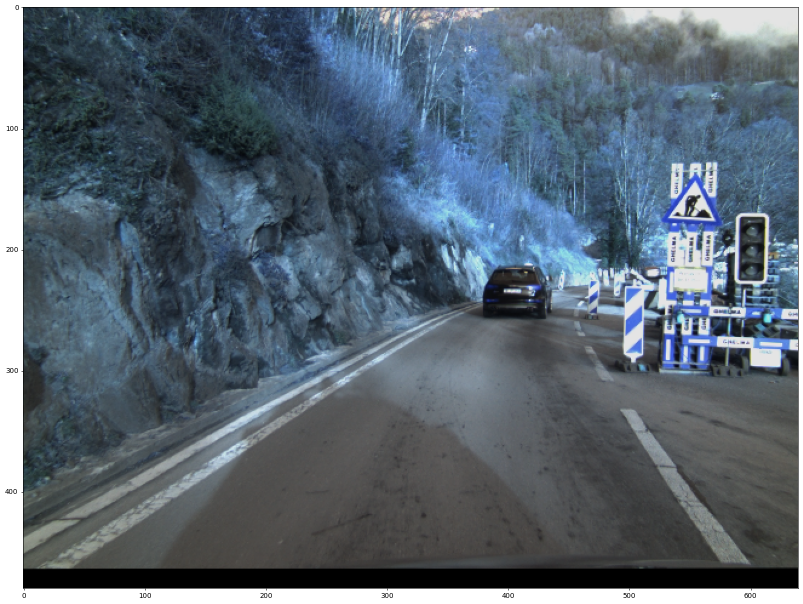

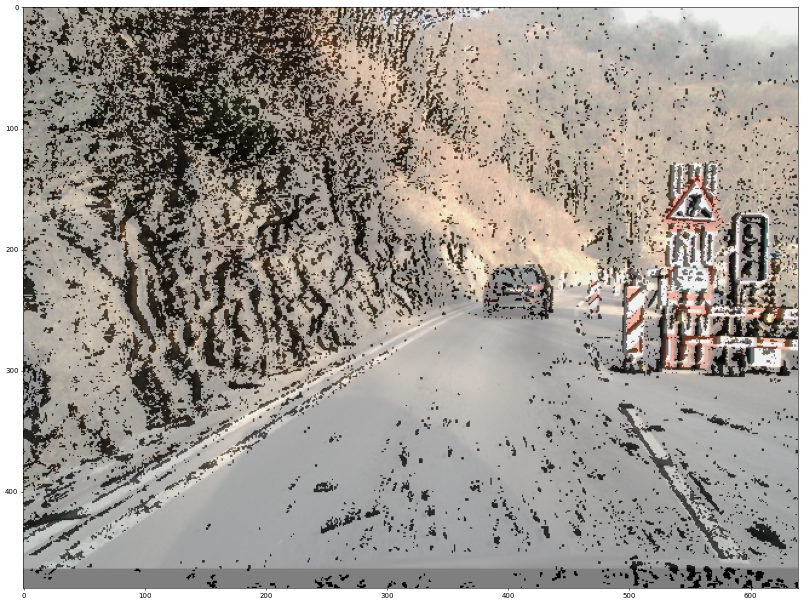

In [16]:
plt.figure(figsize=[20,20], dpi=50)
plt.imshow(dst.astype(np.uint8))

hikaku = cv2.addWeighted(dst[:,:,[2,1,0]].astype(np.float64), 0.5, (left_event_3c).astype(np.float64), 0.5, 0)
plt.figure(figsize=[20,20], dpi=50)
plt.imshow(hikaku.astype(np.uint8))

# Update: utilizing calibration patterns

In [18]:
K0 = np.array([
    [555.662724236466, 0, 342.5725306057865],
    [0, 555.8306341927942, 215.26831427862848],
    [0,0,1]
])

D0 = np.array([-0.09094341408134071, 0.18339771556281387, -0.0006982341741678465, 0.00041396758898911876])

K1 = np.array([
    [1265.9548928992174, 0, 709.88966878899],
    [0, 1266.664879104256, 570.6429565558167],
    [0, 0, 1]
])

D1 = np.array([-0.4227114021699026, 0.1854921374271348, 0.000799026799365846, -0.0009614642754642184])

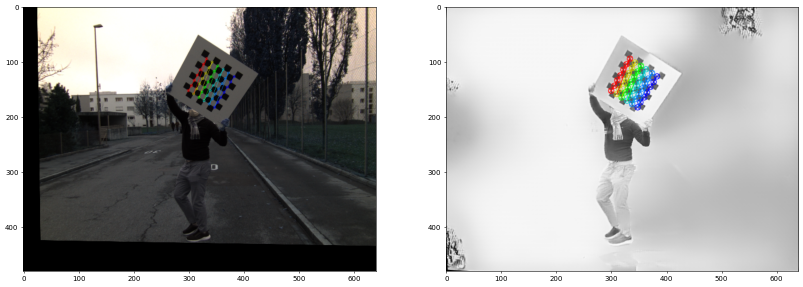

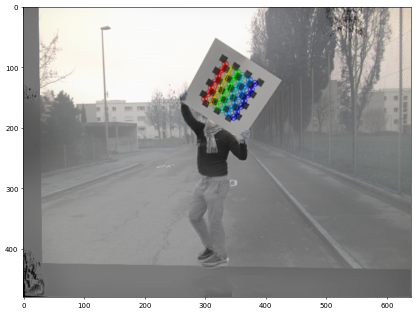

In [19]:
# use a relatively distant calibration pattern
img_left_path = "/media/runqiu/data/DSEC_rpg/calibration_patterns/left_camera/001578.png"
event_left_path = "/media/runqiu/data/DSEC_rpg/calibration_patterns/left_event/001578.png"
img_left = cv2.imread(img_left_path)
event_left = cv2.imread(event_left_path)

# undistort the calibration patterns
img_left_lin = cv2.undistort(img_left, K1, D1)
event_left_lin = cv2.undistort(event_left, K0, D0)

# detect corners
pattern_size = (7,6)
def detectCorners(img, pattern_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(img, pattern_size)
    if found:
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
        corners = cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
    else:
        print("not corners found!")
        
    return corners
corners_img = detectCorners(img_left_lin, pattern_size)
corners_event = detectCorners(event_left_lin, pattern_size)

#draw corners
def drawCorners(img, corners, pattern_size):
    img = cv2.drawChessboardCorners(img, pattern_size, corners, True)
    return img
img_left_lin_corners = drawCorners(img_left_lin, corners_img, pattern_size)
event_left_lin_corners = drawCorners(event_left_lin, corners_event, pattern_size)

# calculate transformation and warp the image by points correspondence
pts_img = np.squeeze(corners_img)[[0,6,-6,-1],:].astype(np.float32)
pts_event = np.squeeze(corners_event)[[0,6,-6,-1],:].astype(np.float32)
M = cv2.getPerspectiveTransform(pts_img, pts_event)
img_left_lin_warp = cv2.warpPerspective(img_left_lin, M, (640,480))

plt.figure(figsize=[20,20], dpi=50)
plt.subplot(121)
plt.imshow(img_left_lin_warp)
plt.subplot(122)
plt.imshow(event_left_lin_corners)

hikaku = cv2.addWeighted(img_left_lin_warp, 0.5, event_left_lin_corners, 0.5, 0)
plt.figure(figsize=[10,10], dpi=50)
plt.imshow(hikaku)

In [20]:
print("get the perspective transformation matrix!")
print(M)

get the perspective transformation matrix!
[[ 4.42135345e-01  7.10558067e-03  2.49903694e+01]
 [ 6.26719425e-03  4.47057622e-01 -4.26173047e+01]
 [-3.05002130e-06  3.56770217e-05  1.00000000e+00]]
